In [1]:
import glob
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [3]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [5]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [6]:
figure_dir = "/project/dinner/scguo/kaiB/dga/figures"

In [7]:
n_rep = 48  # replica number

output_names = [
    "gs_d91r",
    "fs_d91r",
    "d91r_05_31",
    "d91r_06_00",
    "remd_d91r_06_00_23_34423",
    "remd_d91r_06_00_19_42383",
    "remd_d91r_06_00_21_33547",
    "remd_d91r_06_00_25_30869",
]
output_dirs = ["gs_p2.5", "fs_p2.5", "05_31", "06_00", "rerun_0", "rerun_1", "rerun_2", "rerun_3"]
work_dir = "/project/dinner/scguo/kaiB/remd/d91r_iso"

In [8]:
heads = [
    "gs_p2.5_gs_p2.5",
    "fs_p2.5_fs_p2.5",
    "05_31_05_31",
    "06_00_06_00",
    "rerun_0_rerun_0",
    "rerun_1_rerun_1",
    "rerun_2_rerun_2",
    "rerun_3_rerun_3",
]

In [9]:
def load_cvs():
    fs_qtots, f_rmsds, p_rmsds, r_rmsds = [], [], [], []
    q_gs_all, q_gs, q_fs_all, q_fs, q_core = [], [], [], [], []

    for d, head in zip(output_dirs, heads):
        fs_qtots.extend(np.load(f"{work_dir}/{d}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
        f_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
        p_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
        r_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))

        q_gs_all.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_gs_all.pkl", allow_pickle=True))
        q_gs.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_gs.pkl", allow_pickle=True))
        q_fs_all.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_fs_all.pkl", allow_pickle=True))
        q_fs.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_fs.pkl", allow_pickle=True))
        q_core.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_core.pkl", allow_pickle=True))

    fs_qtots = np.asarray([traj[:, start_frame:end_frame:skip] for traj in fs_qtots])
    f_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in f_rmsds])
    r_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in r_rmsds])
    p_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in p_rmsds])

    q_gs_all = np.asarray([traj[start_frame:end_frame:skip] for traj in q_gs_all])
    q_fs_all = np.asarray([traj[start_frame:end_frame:skip] for traj in q_fs_all])
    q_gs = np.asarray([traj[start_frame:end_frame:skip] for traj in q_gs])
    q_fs = np.asarray([traj[start_frame:end_frame:skip] for traj in q_fs])
    q_core = np.asarray([traj[start_frame:end_frame:skip] for traj in q_core])

    return fs_qtots, f_rmsds, p_rmsds, r_rmsds, q_gs_all, q_gs, q_fs_all, q_fs, q_core

In [10]:
def load_omegas():
    omegas = []
    for d, n in zip(output_dirs, output_names):
        for i in np.arange(n_rep):
            j = str(i).zfill(2)
            omegas.append(
                np.load(f"{work_dir}/{d}/outputs/{n}.run.{j}_Omega.npy")[start_frame:end_frame:skip]
            )
    return np.array(omegas)

In [11]:
start_frame = 10000  # skip first _ frames
end_frame = 42000
skip = 1  #

fs_qtots, f_rmsds, p_rmsds, r_rmsds, q_gs_all, q_gs, q_fs_all, q_fs, q_core = load_cvs()
omegas = load_omegas()

In [12]:
fs_qtots.shape

(384, 8, 32000)

In [13]:
weights_all_ts = []
for t in [87, 89, 91]:
    weights = np.load(f"../../../dga/new_{t}/data/mbar_weights.npy")
    weights_all_ts.append(weights)

In [14]:
c_green = fs_qtots[:, 4] - fs_qtots[:, 5]
c_blue = fs_qtots[:, 6] - fs_qtots[:, 7]
c_orange = fs_qtots[:, 2] - fs_qtots[:, 3]
c_0 = fs_qtots[:, 0] - fs_qtots[:, 1]

In [15]:
n_cis = np.sum((np.abs(omegas[..., 3:]) <= (np.pi / 2.0)).astype(int), axis=-1)
p63_cis = (np.abs(omegas[..., 3]) <= (np.pi / 2.0)).astype(int)
p70_cis = (np.abs(omegas[..., 4]) <= (np.pi / 2.0)).astype(int)
p71_cis = (np.abs(omegas[..., 5]) <= (np.pi / 2.0)).astype(int)
p72_cis = (np.abs(omegas[..., 6]) <= (np.pi / 2.0)).astype(int)

In [17]:
cvs = dict(
    blue=c_blue,
    green=c_green,
    orange=c_orange,
    c0=c_0,
    r_rmsd=r_rmsds,
    q_gs_all=q_gs_all,
    q_fs_all=q_fs_all,
    q_core=q_core,
    n_cis=n_cis,
    q_gs=q_gs,
    q_fs=q_fs,
    q_diff=q_fs - q_gs,
)
labels = dict(
    blue=r"$Q_{\mathrm{fs}, \alpha3}-Q_{\mathrm{gs}, \beta4}$",
    green=r"$Q_{\mathrm{fs}, \beta4}-Q_{\mathrm{gs}, \alpha3}$",
    orange=r"$Q_{\mathrm{fs} ,\beta3}-Q_{\mathrm{gs}, \alpha2}$",
    c0=r"$Q_{\mathrm{fs}, \alpha2}-Q_{\mathrm{gs}, \beta3}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{fs, C}}-Q_{\mathrm{gs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1.3, 1),
    green=(-1, 1.3),
    orange=(-1, 1.3),
    c0=(-1.3, 1),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

/scratch/local/jobs/20766144/ipykernel_1401270/1922513369.py:13: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


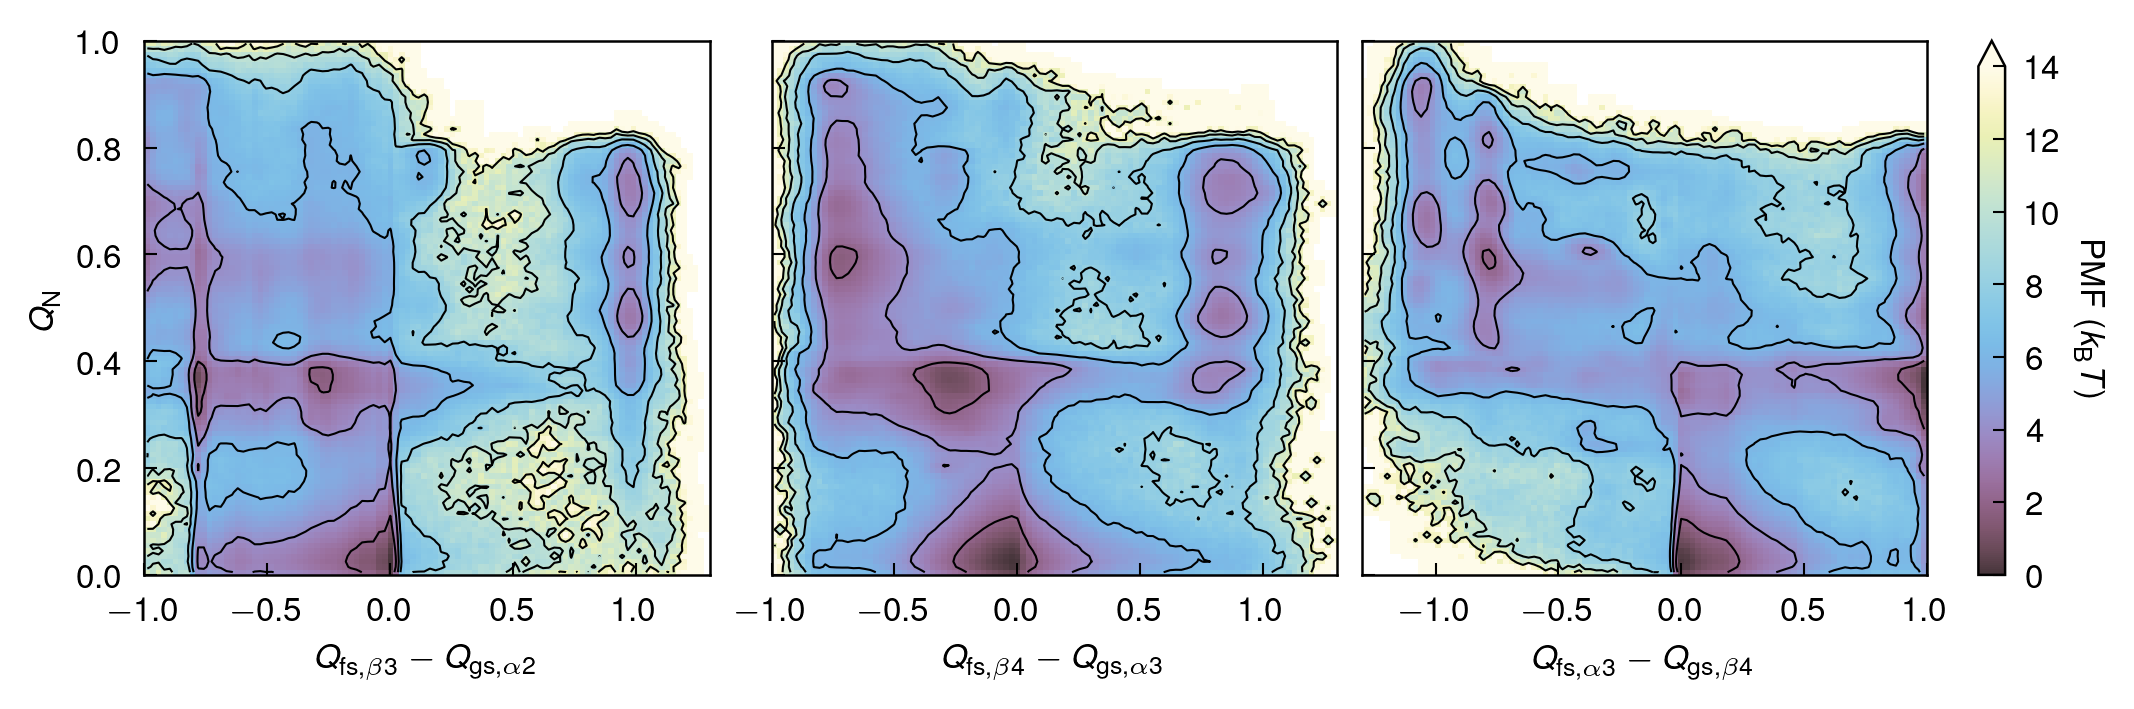

In [18]:
# plot PMFs of different cvs
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharey=True, constrained_layout=True)

ye = np.linspace(*lims["q_core"], 101)
yc = (ye[1:] + ye[:-1]) / 2

for ax, cv in zip(axes, ["orange", "green", "blue"]):
    xe = np.linspace(*lims[cv], 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density2d(cvs[cv], q_core, weights_all_ts[0], xe, ye)
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv])
    ax.set_ylabel(labels["q_core"])
    ax.label_outer()

cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

/scratch/local/jobs/18656226/ipykernel_1644930/3947638617.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


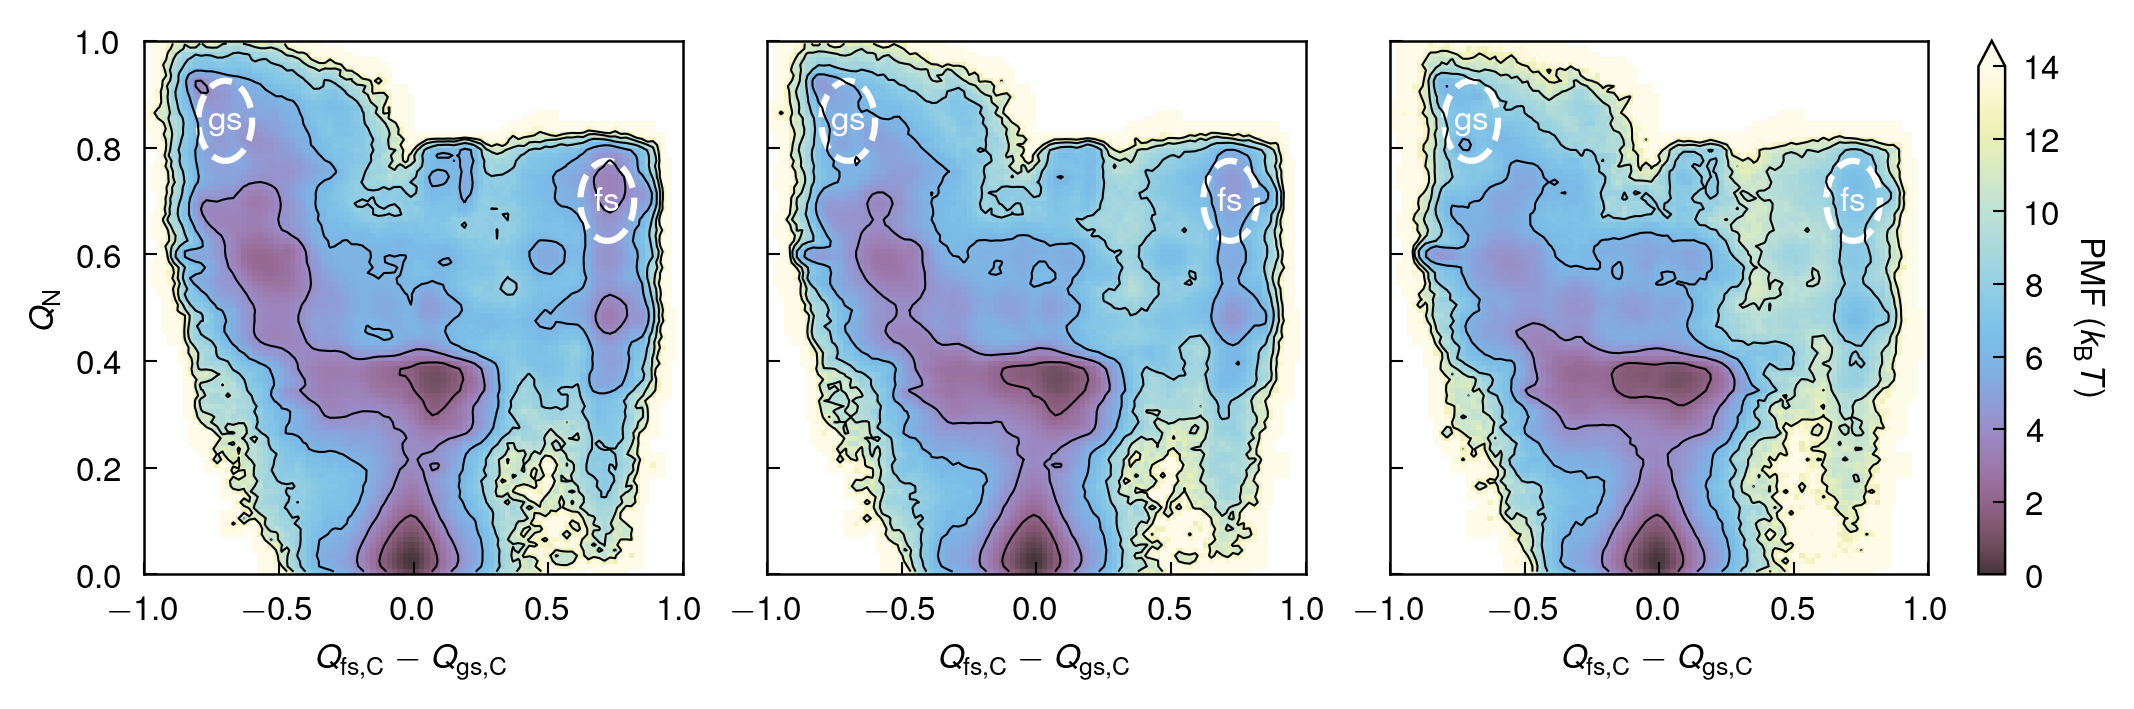

In [18]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, weights in zip(axes, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        weights,
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(-0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(-0.7, 0.85, "gs", ax=ax, color="white")
    pplt.text(0.72, 0.7, "fs", ax=ax, color="white")
fig.savefig(f"{figure_dir}/pmfs_qdiff_qcore_remd.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/18656226/ipykernel_1644930/1922387737.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


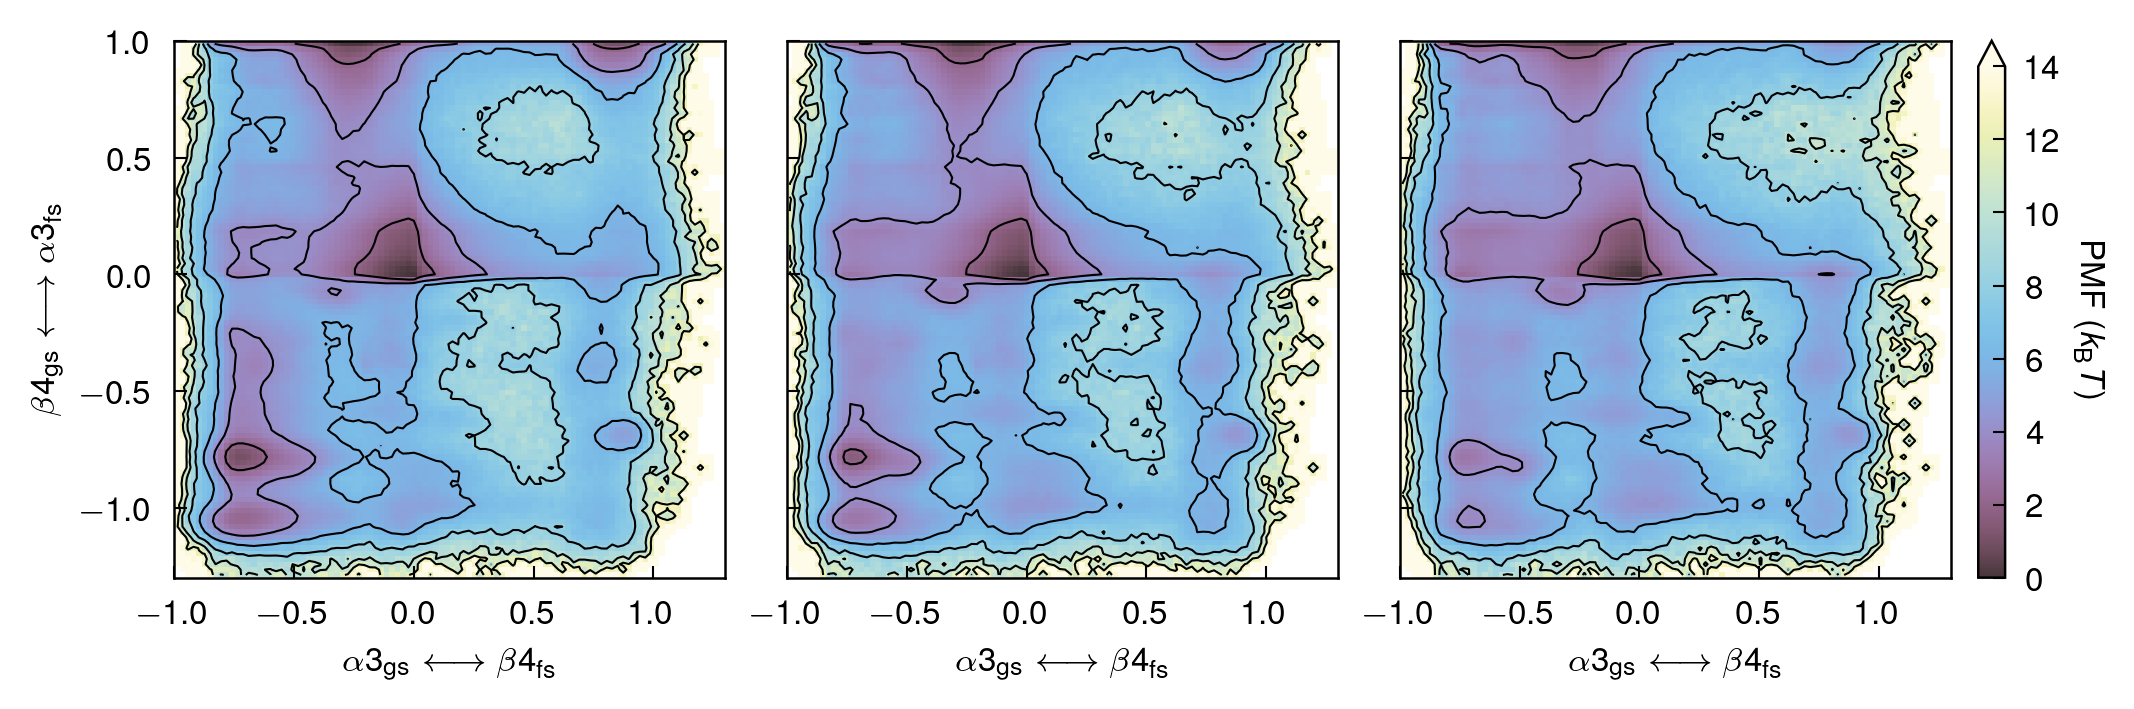

In [19]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, weights in zip(axes, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        weights,
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)
fig.savefig(f"{figure_dir}/pmfs_gb_remd.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/18656226/ipykernel_1644930/2509249336.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


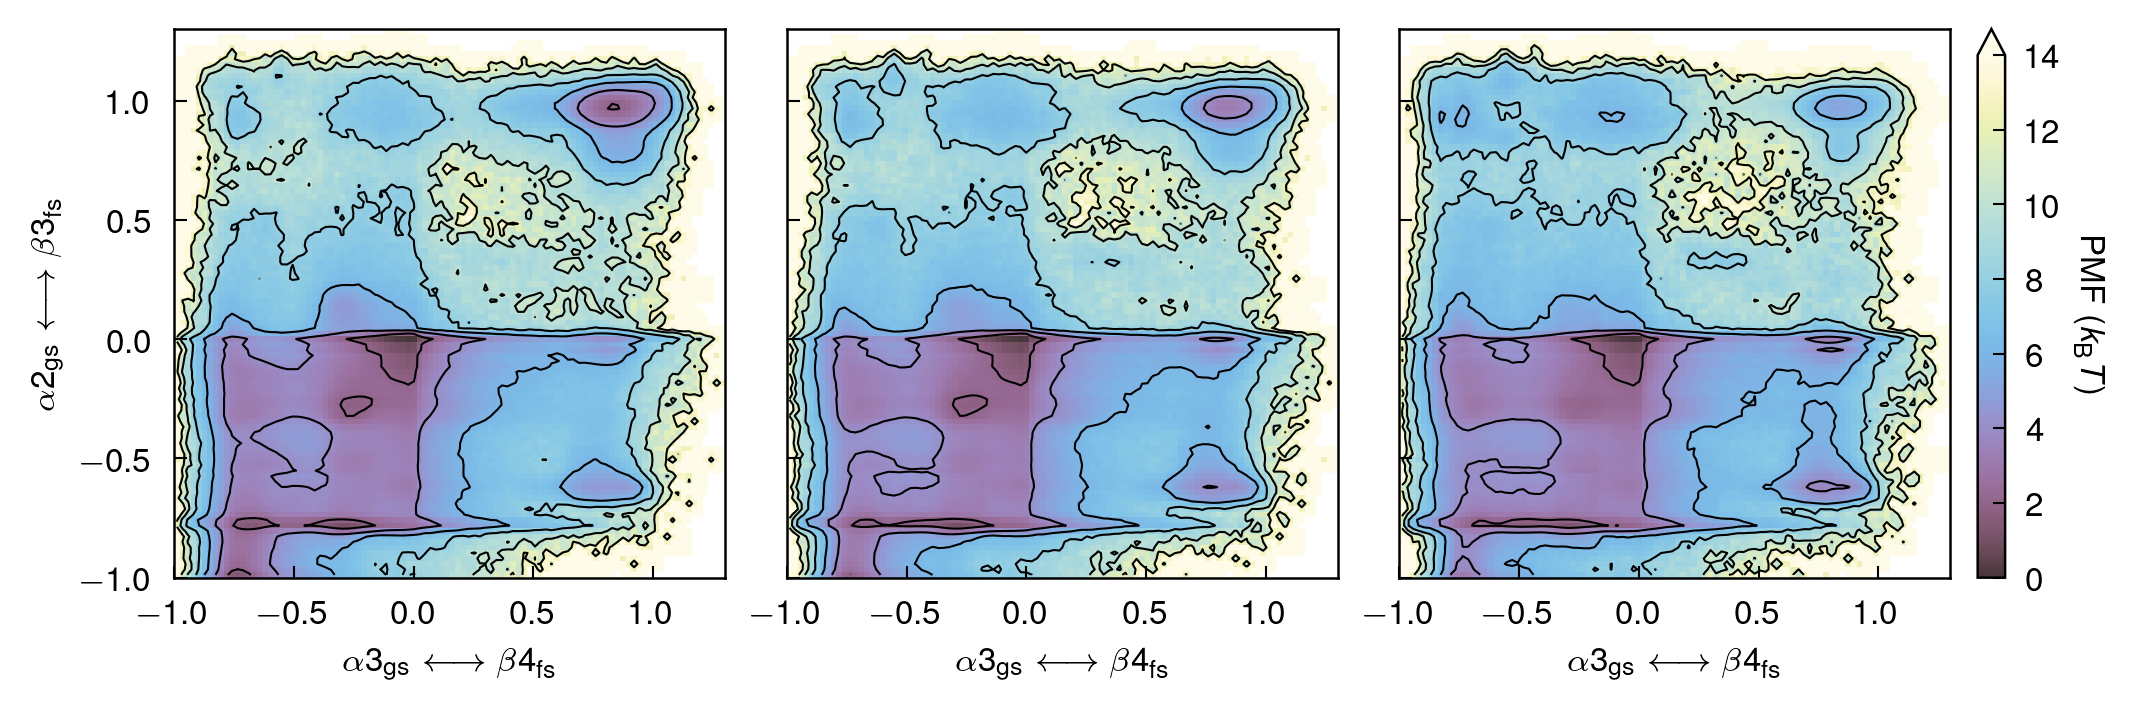

In [20]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "orange"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, weights in zip(axes, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        weights,
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)
fig.savefig(f"{figure_dir}/pmfs_go_remd.pdf", bbox_inches='tight', dpi=400)